<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Object Detection Model

In this notebook, we give an introduction to training an object detection model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a FasterRCNN object detection model. We also cover one of the most common ways to store data on a file system for this type of problem.

To learn more about how object detection work, visit our [FAQ](../FAQ.md).

## Initialization

In [8]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [2]:
import sys

sys.path.append("../../")

import os
import time
from pathlib import Path
from PIL import Image
from random import randrange
from typing import Tuple
import torch
from torchvision import transforms

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import (
    display_bounding_boxes,
    plot_boxes,
    plot_pr_curves,
    BoundingBoxParams,
)
from utils_cv.detection.model import DetectionLearner, get_bounding_boxes, get_transform
from utils_cv.common.gpu import which_processor

which_processor()

ImportError: cannot import name 'BoundingBoxParams'

This shows your machine's GPUs (if has any) and the computing device `torch/torchvision` is using.

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [3]:
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS = 10
LEARNING_RATE = 0.005

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

---

# Prepare Object Detection Dataset

In this notebook, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds. The helper function downloads and unzips data set to the `ComputerVision/data` directory.

Set that directory in the `path` variable for ease of use throughout the notebook.

In [4]:
path = Path(DATA_PATH)
os.listdir(path)

['.DS_Store', 'annotations', 'images']

You'll notice that we have two different folders inside:
- `/images`
- `/annotations`

This format for object detection is fairly common.

```
/data
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- annotations
|   +-- image1.xml
|   +-- image2.xml
|   +-- ...
+-- ...
```

Each image corresponds to an xml file. Each xml file contains information on where its corresponding image file is located. It also contains information about the bounding boxes and the object categories. In this example, our fridge object dataset is annotated in Pascal VOC format. This is one of the most common formats for labelling object detection datasets.

```xml
<!-- Example Pascal VOC annotation -->
<annotation>
    <folder>images</folder>
    <filename>1.jpg</filename>
    <path>../images/1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>499</width>
        <height>666</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>

    <object>
        <name>carton</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>173</ymin>
            <xmax>233</xmax>
            <ymax>521</ymax>
        </bndbox>
    </object>
</annotation>
```

You'll notice that inside the annotation xml file, we can see which image the file references `<path>`, the number of `<objects>` in the image, that the image is of (`<name>`) and the bounding box of that object (`<bndbox>`).

# Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use. In short, we'll need to create a class and implement the `__getitem__` method. More information here: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset

To make it more convinient, we've created a `DetectionDataset` class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class. 

In [5]:
dataset = DetectionDataset(DATA_PATH, train_test_ratio=0.7)

Inspect our Datasets/DataLoaders to make sure the train/test split looks right.

In [6]:
print(
    f"Training dataset: {len(dataset.train_ds)} | Training DataLoader: {dataset.train_dl} \nTesting dataset: {len(dataset.test_ds)} | Testing DataLoader: {dataset.test_dl} \n"
)

Training dataset: 90 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7fd773c0d7b8> 
Testing dataset: 38 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7fd773c0ddd8> 



Lets visualize some of the images to make sure the annotation looks correct.

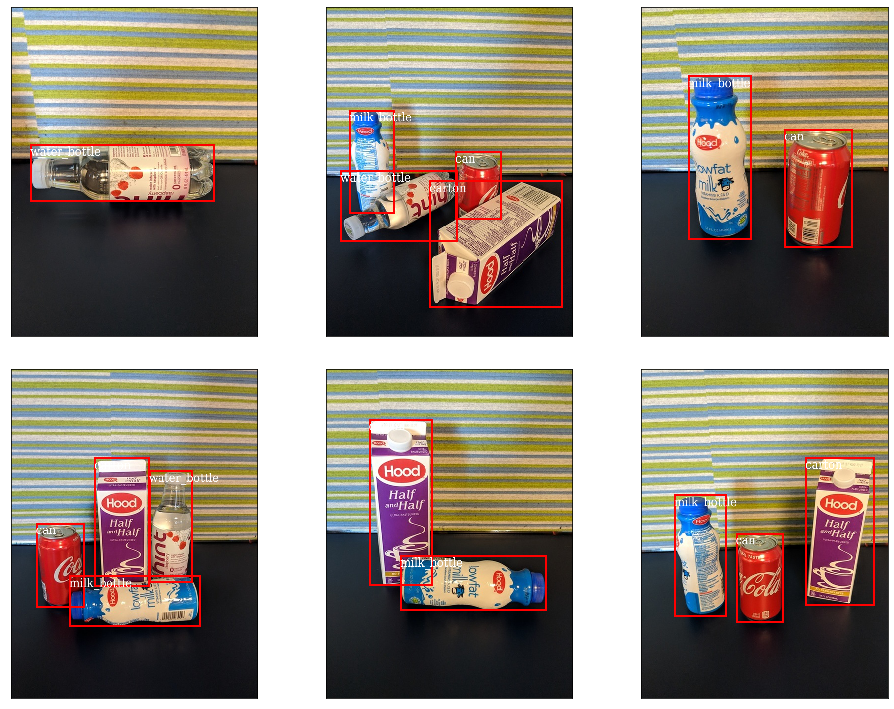

In [9]:
dataset.show_batch(rows=2)

# Finetune a Pretrained Model

For the DetectionLearner, we use Faster R-CNN as the default model, and Stochastic Gradient Descent as our default optimizer. 

Our Faster R-CNN model is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When we initialize the DetectionLearner, the object will perform the following steps:
1. set the model to the torchvision's Faster R-CNN
1. setup the optimizer, SGD in our case
1. set a learning rate scheduler to torch.optim.lr_scheduler.StepLR

In [10]:
detector = DetectionLearner(dataset, LEARNING_RATE)

NameError: name 'DetectionLearner' is not defined

Lets also check that our model, optimizer and learning rate scheduler are properly set.

In [11]:
print(
    f"Learning rate scheduler: {detector.lr_scheduler}\nOptimizer: {type(detector.optimizer)}\nModel: {type(detector.model)}"
)

NameError: name 'detector' is not defined

Fine-tune the model using our training data loader (`train_dl`) and evaluate our results using our testing data loader (`test_dl`).

In [12]:
detector.fit(EPOCHS, print_freq=30)

NameError: name 'detector' is not defined

Visualize the loss over time.

In [13]:
detector.plot_losses()

NameError: name 'detector' is not defined

# Evaluate

We can simply run the `evaluate()` method on our detector to evaluate the results.

Below, you'll notice the notation IoU=0.5:0.95 in the results above. This means: the average mAP over different IoU thresholds, from 0.5 to 0.95, at step size of 0.05 (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95).

In [ ]:
e = detector.evaluate()

Plot precision-recall curves. We'll use the `plot_pr_curves` function to plot the PR of each IoU threshold, and also the average over the IoU thresholds.

In [ ]:
plot_pr_curves(e)

Lets plot the ground truth vs predictions. By default, the function will use the test dataset, but we can explicity tell it to do so. 

The red boxes represents the ground truth while the green represents the predected bounding box.

In [ ]:
detector.show_preds(ds=detector.test_ds, rows=2)

# Inference

We can use the detector to inference new images. Start by getting a new image. In this case, we'll reuse a random image in our dataset and pretend it is a new image.

In [ ]:
new_im_path = dataset.root / dataset.image_folder / dataset.ims[randrange(len(dataset))]
new_im_path

We can use the inference function:

In [ ]:
new_im = Image.open(new_im_path)
preds = detector.inference(new_im)

Now that we have our predictions, lets plot the predictions on our image.

In [ ]:
pred_labels, pred_boxes = get_bounding_boxes(preds)
bbox_params = BoundingBoxParams(rect_color=(0, 255, 0))

display_bounding_boxes(
    pred_boxes,
    [dataset.categories[l] for l in pred_labels],
    new_im_path,
    bbox_params=bbox_params,
)